In [239]:
from pathlib import Path
import random
import json
from shutil import copyfile

import numpy as np
import cv2

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from tensorflow_addons.losses import GIoULoss
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data

In [240]:
data_path = r"E:\code\projects\frc-vision\datasets\target-dataset\target-imgs-datset\vision-example-video-camera0-lowres"
parent_dir = Path(data_path)
list(parent_dir.iterdir())

labels_path = parent_dir / "ann"
imgs_path = parent_dir / "img"
next(labels_path.iterdir())
next(imgs_path.iterdir())

[WindowsPath('E:/code/projects/frc-vision/datasets/target-dataset/target-imgs-datset/vision-example-video-camera0-lowres/ann'),
 WindowsPath('E:/code/projects/frc-vision/datasets/target-dataset/target-imgs-datset/vision-example-video-camera0-lowres/img'),
 WindowsPath('E:/code/projects/frc-vision/datasets/target-dataset/target-imgs-datset/vision-example-video-camera0-lowres/meta.json')]

WindowsPath('E:/code/projects/frc-vision/datasets/target-dataset/target-imgs-datset/vision-example-video-camera0-lowres/ann/frame_00000.png.json')

WindowsPath('E:/code/projects/frc-vision/datasets/target-dataset/target-imgs-datset/vision-example-video-camera0-lowres/img/frame_00000.png')

In [241]:
test = Path(r"E:\code\projects\frc-vision\datasets\target-dataset\target-imgs-datset\vision-example-video-camera0-lowres\ann\frame_00000.png.json")
test.stem

'frame_00000.png'

In [242]:
Xs = []
ys = []

for label_path in labels_path.iterdir():
    with open(str(label_path)) as f:
        label_json = json.load(f)
        if len(label_json["objects"]) == 0:
            points = np.ones((6, 2), dtype=float) - 2
        else:
            for obj in label_json["objects"]:
                if obj["classTitle"] == "Hexagon Target":
                    img_path = imgs_path / label_path.stem
                    img = cv2.imread(str(img_path))
                    height, width, _ = img.shape
                    img = cv2.resize(img, (150, 150))
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    
                    points = label_json["objects"][0]["points"]["exterior"]
                    points.sort()
                    points = np.array(points, dtype=float)
                    points[:, 0] /= width
                    points[:, 1] /= height
                    points = points.flatten()
                    
                    Xs.append(img)
                    ys.append(points)
                else:
                    print(obj["classTitle"])

In [243]:
Xs = np.array(Xs, dtype=float)
ys = np.array(ys, dtype=float)

In [244]:
len(Xs)
len(ys)
Xs[0].shape
ys[0].shape

75

75

(150, 150, 3)

(12,)

## Train-Test Split

In [245]:
SPLIT = 0.9
split_idx = int(SPLIT * len(Xs))

train_X = Xs[:split_idx]
train_y = ys[:split_idx]

test_X = Xs[split_idx:]
test_y = ys[split_idx:]

In [246]:
len(train_X)
len(test_X)

67

8

# Model

In [247]:
local_weights_file = Path(
    "C:/Users/Ani Aggarwal/Documents/code/tf-dev-prep/tf-dev-prep-storage/models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
)

pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3), include_top=False, weights=None
)
pre_trained_model.load_weights(str(local_weights_file))

for layer in pre_trained_model.layers:
    layer.trainable = False

# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer("mixed7")
print("last layer output shape: ", last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [226]:
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation="relu")(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(12, activation="sigmoid")(x)

model = Model(pre_trained_model.input, x)

model.compile(
    optimizer="sgd", loss="binary_crossentropy", metrics=["accuracy"]
)

# Training

In [248]:
history = model.fit(train_X, train_y, batch_size=8, epochs=100, validation_data=(test_X, test_y))

Epoch 1/100
9/9 [==============================] - 0s 22ms/step - loss: 0.6275 - accuracy: 0.6866 - val_loss: 0.6613 - val_accuracy: 0.2500
Epoch 2/100
9/9 [==============================] - 0s 18ms/step - loss: 0.6243 - accuracy: 0.6418 - val_loss: 0.6619 - val_accuracy: 0.2500
Epoch 3/100
9/9 [==============================] - 0s 17ms/step - loss: 0.6303 - accuracy: 0.7313 - val_loss: 0.6762 - val_accuracy: 0.2500
Epoch 4/100
9/9 [==============================] - 0s 18ms/step - loss: 0.6318 - accuracy: 0.7313 - val_loss: 0.6563 - val_accuracy: 0.2500
Epoch 5/100
9/9 [==============================] - 0s 18ms/step - loss: 0.6344 - accuracy: 0.7313 - val_loss: 0.7027 - val_accuracy: 0.2500
Epoch 6/100
9/9 [==============================] - 0s 22ms/step - loss: 0.6333 - accuracy: 0.7313 - val_loss: 0.6580 - val_accuracy: 0.2500
Epoch 7/100
9/9 [==============================] - 0s 19ms/step - loss: 0.6284 - accuracy: 0.7313 - val_loss: 0.6682 - val_accuracy: 0.2500
Epoch 8/100
9/9 [===

## Graphing

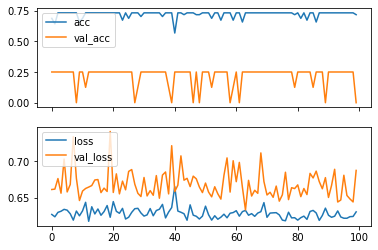

In [249]:
%matplotlib inline

import matplotlib.pyplot as plt

# -----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
# -----------------------------------------------------------
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(acc))  # Get number of epochs

# ------------------------------------------------
# Plot training and validation accuracy per epoch
# ------------------------------------------------
fig, ax = plt.subplots(2, 1, sharex=True)

ax[0].plot(acc)
ax[0].plot(val_acc)
ax[0].legend(("acc", "val_acc"), loc="upper left")

ax[1].plot(loss)
ax[1].plot(val_loss)
ax[1].legend(("loss", "val_loss"), loc="upper left")

# Testing

(1172, 1600)

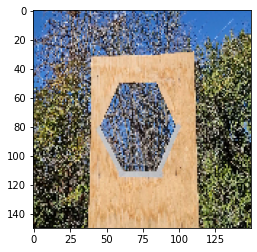

In [250]:
test_path = Path(r"C:\Users\Ani Aggarwal\Documents\code\frc\2021-unified\learn\ani\vision\target-imgs\mid-target.jpg")
test_img = cv2.imread(str(test_path))
height, width, _ = test_img.shape
test_img = cv2.resize(test_img, (150, 150))
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

height, width
plt.imshow(test_img)

In [251]:
output = model.predict(np.expand_dims(test_img, 0)).squeeze(0)
output = output.reshape(6, 2)
output[:, 0] *= 150
output[:, 1] *= 150
output = output.astype(int)
output

array([[83, 64],
       [73, 67],
       [82, 65],
       [73, 68],
       [86, 76],
       [73, 70]])

In [252]:
for x, y in output:
    test_img = cv2.circle(test_img, (x, y), 2, (0, 255, 0), -1)

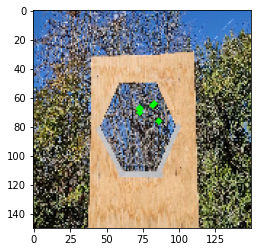

In [253]:
plt.imshow(test_img)